# Quality Control


## - Total number of reads (All, Pass, Pass + Adapters,  Pass + Adapters + Mapped) - DONE

## - Mean, median, and N50 read length for reads that aligned to the human genome - DONE

## - Percent of unique full length and full length reads per sample - DONE

## - XY plot of percent full length reads as a function of median read length - DONE

## - XY plot of percent full length reads as a function of transcript length - DONE

## - XY plot of full length reads vs transcript length - DONE

## - XY plot CPM vs full length reads - DONE

## - Histogram of CPM expression at gene and transcript level - DONE

## - Total number of transcripts and genes across CPM threshold - DONE

## - ERCC correlation plots - DONE

## - Manually add Q-score distribution, 3' bias and any other relevant plots from MultiQC - DONE





# Library Import and Functions

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from scipy import stats


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
function name: get_real_transcript_length

purpose: create dataframe containing exonic transcript length and transcript_id

input: bambu gtf file

output: dataframe with two columns, transcript_id and real_transcript_length
'''

def get_real_transcript_length(annotation):
    
    annotation = parse_df_columns(annotation, is_ref=False)
    
    annotation["real_transcript_length"] = abs(annotation["end"] - annotation["start"])
    
    exon_annotation = annotation.loc[annotation["type"] == "exon"][["transcript_id", "real_transcript_length"]].copy()
    
    df_transcript_length = exon_annotation.groupby("transcript_id").sum()
    
    df_transcript_length.reset_index(inplace=True)
    
    return df_transcript_length    

In [3]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [4]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns[1:].tolist()
        list_new_names = ["gene_id"]
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [5]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [6]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [7]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## Store QC data from MultiQC into a dataframe and load annotations

In [8]:
## Create dataframe to store MultiQC data

sample_names = ['sample_579_PAG75663', 'sample_1131_PAM44580','sample_1218_PAM43779', 'sample_1304_PAM44487',
 'sample_1271_PAM44815', 'sample_5356_PAM42933', 'sample_1163_PAM44604', 'sample_5295_PAG77944',
 'sample_5292_PAG75292', 'sample_1092_PAM41667', 'sample_1186_PAM43869', 'sample_1291_PAG71816']


percent_mito = [13, 7, 23, 6, 9, 9, 8, 23, 13, 10, 8, 18]

total_reads = [156.3, 166.6, 196.7, 119.4, 108.4, 158.9, 104.1, 163.9, 129.7, 163.5, 183.0, 121.2]

pass_reads = [116.6, 120.1, 153.6, 85.9, 86.8, 119.2, 84.8, 122.7, 98.3, 121.2, 129.7, 91.8]

percent_both_primers = [0.817, 0.862, 0.873, 0.813, 0.773, 0.806, 0.746, 0.765, 0.801, 0.826, 0.871, 0.768]

mapped_reads = [51.8, 22.5, 46.7, 22.6, 44.6, 28.0, 49.1, 40.4, 45.0, 36.1, 34.2, 40.1]

n50_mapped = [831, 1120, 699, 1510, 1370, 1560, 1090, 815, 1040, 1010, 802, 954]

median_read_length_mapped = [336, 245, 286, 422, 458, 327, 500, 354, 393, 259, 328, 416]



dictionary_qc = {'sample_name': sample_names, 'Mapped pass N50': n50_mapped,
                "Median read length mapped": median_read_length_mapped, "All reads": total_reads, 
                "Pass reads": pass_reads, "Mapped pass reads with both primers": mapped_reads, "Percent both primers": percent_both_primers,
                 "percent mito": percent_mito}

df_qc_stats = pd.DataFrame(data=dictionary_qc)

df_qc_stats["Pass reads with both primers"] = df_qc_stats["Pass reads"].copy() * df_qc_stats["Percent both primers"].copy()

In [9]:
## Open original reference
ref = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_sy_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

ref_copy = ref.copy()

ref_transcript_length = get_real_transcript_length(ref_copy)

ref = parse_df_columns(ref, is_ref=False)

ref = ref.loc[ref["type"]=="transcript"].copy()

# Total reads plot

In [10]:
df_read_numbers = df_qc_stats[["sample_name", "All reads", "Pass reads", 
                               "Pass reads with both primers", "Mapped pass reads with both primers"]].copy()

df_read_numbers_melt = pd.melt(df_read_numbers, id_vars=['sample_name'], value_vars=["All reads", "Pass reads", 
                               "Pass reads with both primers", "Mapped pass reads with both primers"], value_name="Million reads")



In [11]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (59*mm, 72*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

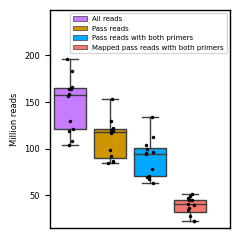

In [12]:
sns.boxplot(data=df_read_numbers_melt, y="Million reads", x="variable",
           saturation=1, palette=[ggplot2_colors[6], ggplot2_colors[1], ggplot2_colors[5], ggplot2_colors[0]],
           showfliers=False, hue="variable", dodge=False, linewidth=1)


sns.stripplot(data=df_read_numbers_melt,  y="Million reads", x="variable",
             color="black", size=2.5)

plt.ylim([15, 249])
plt.xlabel("")
plt.xticks("")
plt.tick_params(bottom=False)
plt.legend(fontsize=5, loc="upper right")


plt.savefig('../../../figures/bernardo/02.quality_control/number_of_reads.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/number_of_reads.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# N50 and median read length plots

In [13]:
df_read_length = df_qc_stats[["sample_name", "Mapped pass N50", "Median read length mapped"]].copy()


df_read_length.columns = ["sample_name", "N50 for mapped reads", "Median read length for mapped reads"]

df_read_length_melt = pd.melt(df_read_length, id_vars=['sample_name'], 
                              value_vars=["N50 for mapped reads", "Median read length for mapped reads"], value_name="Base pairs")


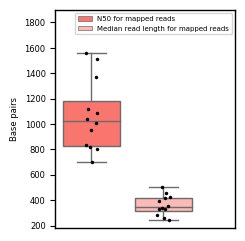

In [14]:
ax = sns.boxplot(data=df_read_length_melt, y="Base pairs", x="variable",
           palette=[ggplot2_colors[0], ggplot2_colors[0]], saturation=1,
           showfliers=False, hue="variable", dodge=False, linewidth=1)


ax2 = sns.stripplot(data=df_read_length_melt,  y="Base pairs", x="variable",
             color="black", size=2.5)

i = 0
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    
    if (i==0 or i==1):
        patch.set_facecolor((r, g, b, 1))
        
    else:
        patch.set_facecolor((r, g, b, 0.5))
        
    i += 1
        

plt.legend(fontsize=5, loc="upper right")
plt.ylim([180, 1900])
plt.xlabel("")
plt.xticks("")
plt.tick_params(bottom=False)




plt.savefig('../../../figures/bernardo/02.quality_control/read_length.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/read_length.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# Percent of unique full length and full length reads per sample

In [15]:
## Import counts matrices

df = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_unique = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/uniqueCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_full = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/fullLengthCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

In [16]:
## Fix column names

df = fix_column_names(df, is_gene=False)
df_unique = fix_column_names(df_unique, is_gene=False)
df_full = fix_column_names(df_full, is_gene=False)

In [17]:
## Change column names for full and unique dataframes

count_columns = df.filter(regex='counts').columns
unique_counts_columns = df_unique.filter(regex='counts').columns
full_count_columns = df_full.filter(regex='counts').columns


unique_counts_columns = [s + "_UNIQUE" for s in unique_counts_columns]
full_counts_columns = [s + "_FULL" for s in full_count_columns]

unique_counts_columns.insert(0, "gene_id")
unique_counts_columns.insert(0, "transcript_id")

full_counts_columns.insert(0, "gene_id")
full_counts_columns.insert(0, "transcript_id")

df_unique.columns = unique_counts_columns
df_full.columns = full_counts_columns

In [18]:
## [sample_name, full_counts, unique_counts, full_counts_no_mito, unique_counts_no_mito, full_counts_mito, unique_counts_mito]
percents_list = [[], [], [], [], [], [], [], []]

for col in count_columns:
    col_unique = col + "_UNIQUE"
    col_full = col + "_FULL"
    
    percent_full = (df_full[col_full].sum()/df[col].sum()) * 100
    percent_unique = (df_unique[col_unique].sum()/df[col].sum()) * 100
       
    percents_list[0].append(col)
    percents_list[1].append(percent_full)
    percents_list[2].append(percent_unique)

In [19]:
## Create dataframe to store percent full length and percent unique reads
sample_names_percents = [s[0:-7] for s in percents_list[0]]


dictionary_percents = {'sample_name': sample_names_percents, 'percent_full': percents_list[1], 
                       "percent_unique": percents_list[2]}

df_percent_stats = pd.DataFrame(data=dictionary_percents)

In [20]:
df_qc_stats = df_qc_stats.merge(df_percent_stats, how="inner", on="sample_name")

In [21]:
df_percent_full_length = df_qc_stats[["sample_name", "percent_full", "percent_unique"]].copy()

df_percent_full_length.columns = ["sample_name", "Uniquely mapped full-length reads", "Uniquely mapped reads"]

df_percent_full_length_melt = pd.melt(df_percent_full_length, id_vars=['sample_name'], 
                              value_vars=["Uniquely mapped full-length reads", "Uniquely mapped reads"], 
                                      value_name="Percent")


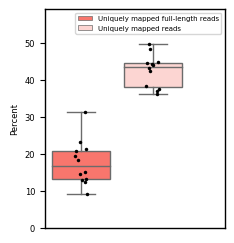

In [22]:
ax = sns.boxplot(data=df_percent_full_length_melt, y="Percent", x="variable",
           palette=[ggplot2_colors[0], ggplot2_colors[0]], saturation=1,
           showfliers=False, hue="variable", dodge=False, linewidth=1)


ax2 = sns.stripplot(data=df_percent_full_length_melt,  y="Percent", x="variable",
             color="black", size=2.5)

i = 0
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    
    if (i==0 or i==1):
        patch.set_facecolor((r, g, b, 1))
        
    else:
        patch.set_facecolor((r, g, b, 0.3))
    
    i += 1


plt.legend(fontsize=5, loc="upper right")
plt.ylim([0, 59])
plt.xlabel("")
plt.xticks("")
plt.tick_params(bottom=False)

plt.savefig('../../../figures/bernardo/02.quality_control/percent_full_length.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/percent_full_length.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# - XY plot of percent full length reads as a function of median read length

# - XY plot of percent full length reads as a function of transcript length

In [23]:
df_qc_stats.head()

,sample_name,Mapped pass N50,Median read length mapped,All reads,Pass reads,Mapped pass reads with both primers,Percent both primers,percent mito,Pass reads with both primers,percent_full,percent_unique
0,sample_579_PAG75663,831,336,156.3,116.6,51.8,0.817,13,95.2622,18.151996,42.407208
1,sample_1131_PAM44580,1120,245,166.6,120.1,22.5,0.862,7,103.5262,9.170098,35.967790
2,sample_1218_PAM43779,699,286,196.7,153.6,46.7,0.873,23,134.0928,14.990351,43.054561
3,sample_1304_PAM44487,1510,422,119.4,85.9,22.6,0.813,6,69.8367,12.793344,38.310060
4,sample_1271_PAM44815,1370,458,108.4,86.8,44.6,0.773,9,67.0964,21.208632,44.372716


In [24]:
df_full_length_xy = df_qc_stats[["sample_name", "Median read length mapped", "Mapped pass N50", 
                             "percent_full", "percent_unique"]].copy()

df_full_length_xy.columns = ["Sample name", "Median read length for mapped reads", "N50 for mapped reads", 
                             "Percent uniquely mapped full-length reads", "Percent uniquely mapped reads"]

In [25]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in mm
rcParams['figure.figsize'] = (59*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

Spearman coefficient: 0.62
Spearman R-squared: 0.39
Spearman p-value: 0.030675895061640132

Pearson coefficient: 0.73
Pearson R-squared: 0.53
Pearson Slope: 0.06
Pearson Intercept: -2.34
Pearson P-value: 0.007449195604747818
Pearson Standard Error: 0.0165 



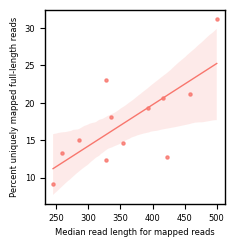

In [26]:
sns.regplot(data=df_full_length_xy, x="Median read length for mapped reads",
            y="Percent uniquely mapped full-length reads", color=ggplot2_colors[0],  scatter_kws={'s':5},
           line_kws={'linewidth':1})


spearman_coeff, spearman_p = stats.spearmanr(df_full_length_xy["Median read length for mapped reads"].copy(),
                                                                     df_full_length_xy["Percent uniquely mapped full-length reads"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_full_length_xy["Median read length for mapped reads"].copy(),
                                                                     df_full_length_xy["Percent uniquely mapped full-length reads"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/full_length_reads_vs_median_read_length.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/full_length_reads_vs_median_read_length.svg',
            dpi=1200, transparent=True, bbox_inches="tight")


Spearman coefficient: 0.7
Spearman R-squared: 0.49
Spearman p-value: 0.011374198642690932

Pearson coefficient: 0.68
Pearson R-squared: 0.46
Pearson Slope: 0.04
Pearson Intercept: 28.8
Pearson P-value: 0.015514055493592435
Pearson Standard Error: 0.013 



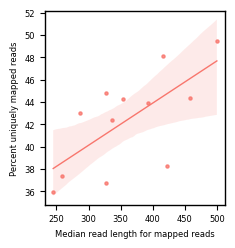

In [27]:
sns.regplot(data=df_full_length_xy, x="Median read length for mapped reads", y="Percent uniquely mapped reads", 
            color=ggplot2_colors[0],scatter_kws={'s':5}, line_kws={'linewidth':1})

spearman_coeff, spearman_p = stats.spearmanr(df_full_length_xy["Median read length for mapped reads"].copy(),
                                                                     df_full_length_xy["Percent uniquely mapped reads"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_full_length_xy["Median read length for mapped reads"].copy(),
                                                                     df_full_length_xy["Percent uniquely mapped reads"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/unique_reads_vs_median_read_length.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/unique_reads_vs_median_read_length.svg',
            dpi=1200, transparent=True, bbox_inches="tight")


Spearman coefficient: -0.34
Spearman R-squared: 0.12
Spearman p-value: 0.27556745095678037

Pearson coefficient: -0.2
Pearson R-squared: 0.04
Pearson Slope: -0.0
Pearson Intercept: 22.07
Pearson P-value: 0.5362467461926548
Pearson Standard Error: 0.0066 



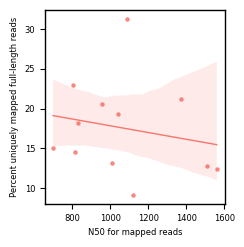

In [28]:
sns.regplot(data=df_full_length_xy, x="N50 for mapped reads", y="Percent uniquely mapped full-length reads", 
            color=ggplot2_colors[0], scatter_kws={'s':5}, line_kws={'linewidth':1})

spearman_coeff, spearman_p = stats.spearmanr(df_full_length_xy["N50 for mapped reads"].copy(),
                                                                     df_full_length_xy["Percent uniquely mapped full-length reads"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_full_length_xy["N50 for mapped reads"].copy(),
                                                                     df_full_length_xy["Percent uniquely mapped full-length reads"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/full_length_reads_vs_n50_read_length.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/full_length_reads_vs_n50_read_length.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

Spearman coefficient: -0.36
Spearman R-squared: 0.13
Spearman p-value: 0.2452650007307772

Pearson coefficient: -0.43
Pearson R-squared: 0.19
Pearson Slope: -0.01
Pearson Intercept: 49.6
Pearson P-value: 0.1611182855599275
Pearson Standard Error: 0.0045 



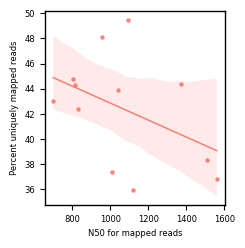

In [29]:
sns.regplot(data=df_full_length_xy, x="N50 for mapped reads", y="Percent uniquely mapped reads", color=ggplot2_colors[0], 
           scatter_kws={'s':5}, line_kws={'linewidth':1})

spearman_coeff, spearman_p = stats.spearmanr(df_full_length_xy["N50 for mapped reads"].copy(),
                                                                     df_full_length_xy["Percent uniquely mapped reads"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_full_length_xy["N50 for mapped reads"].copy(),
                                                                     df_full_length_xy["Percent uniquely mapped reads"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")


plt.savefig('../../../figures/bernardo/02.quality_control/unique_length_reads_vs_n50_read_length.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/unique_length_reads_vs_n50_read_length.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

# XY plot of full length reads vs transcript length

In [30]:
## Calculate cpm
df_cpm = calculate_cpm(df.copy(), is_gene=False)

In [31]:
## Calculate median CPM and create list of transcript names with median CPM > 1
df_cpm["median_CPM"] = df_cpm[df_cpm.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [32]:
df_cpm = df_cpm.loc[df_cpm["median_CPM"] > 1].copy()

In [33]:
transcript_cpm_median_1 = df_cpm["transcript_id"].to_list()

In [34]:
df_full_with_length = df_full.loc[df_full["transcript_id"].isin(transcript_cpm_median_1)].copy()


df_unique_with_length = df_unique.loc[df_unique["transcript_id"].isin(transcript_cpm_median_1)].copy()

In [35]:
df_full_with_length = df_full_with_length.merge(ref_transcript_length, on="transcript_id", how="inner")

In [36]:
df_with_length = df.copy()

df_with_length["total_counts"] = df_with_length[df_with_length.filter(regex='counts').columns].sum(axis=1)

df_full_with_length["total_full_counts"] = df_full_with_length[df_full_with_length.filter(regex='counts').columns].sum(axis=1)

df_unique_with_length["total_unique_counts"] = df_unique_with_length[df_unique_with_length.filter(regex='counts').columns].sum(axis=1)

In [37]:
df_merged_length = df_with_length[["transcript_id", "total_counts"]].merge(
                        df_full_with_length[["transcript_id", "total_full_counts", "real_transcript_length"]],
                        on="transcript_id", how="inner")


df_merged_length = df_merged_length.merge(
                        df_unique_with_length[["transcript_id", "total_unique_counts"]],
                        on="transcript_id", how="inner")

In [38]:
df_merged_length["Percent uniquely mapped full length reads"] = df_merged_length["total_full_counts"]/df_merged_length["total_counts"]

df_merged_length["Percent uniquely mapped reads"] = df_merged_length["total_unique_counts"]/df_merged_length["total_counts"]

In [39]:
df_merged_length.columns

Index(['transcript_id', 'total_counts', 'total_full_counts',
       'real_transcript_length', 'total_unique_counts',
       'Percent uniquely mapped full length reads',
       'Percent uniquely mapped reads'],
      dtype='object')

In [40]:
df_merged_length["Log10 transcript length"] =  np.log10(df_merged_length["real_transcript_length"].copy())

Spearman coefficient: -0.59
Spearman R-squared: 0.35
Spearman p-value: 0.0

Pearson coefficient: -0.52
Pearson R-squared: 0.27
Pearson Slope: -0.76
Pearson Intercept: 3.53
Pearson P-value: 0.0
Pearson Standard Error: 0.0073 



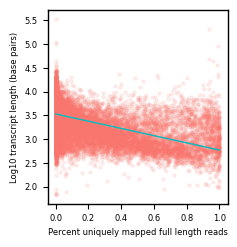

In [41]:
sns.regplot(data=df_merged_length, x="Percent uniquely mapped full length reads", 
            y="Log10 transcript length", scatter_kws={"color": ggplot2_colors[0], "alpha": 0.1, "s": 5},
            line_kws={"color": ggplot2_colors[4], "alpha": 1, "linewidth":1})

plt.ylabel("Log10 transcript length (base pairs)")

spearman_coeff, spearman_p = stats.spearmanr(df_merged_length["Percent uniquely mapped full length reads"].copy(),
                                                                     df_merged_length["Log10 transcript length"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_merged_length["Percent uniquely mapped full length reads"].copy(),
                                                                     df_merged_length["Log10 transcript length"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/transcript_length_vs_full_length_uniquely_mapped.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/transcript_length_vs_full_length_uniquely_mapped.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

Spearman coefficient: -0.16
Spearman R-squared: 0.03
Spearman p-value: 2.014816942265464e-163

Pearson coefficient: -0.16
Pearson R-squared: 0.03
Pearson Slope: -0.14
Pearson Intercept: 3.49
Pearson P-value: 1.0639314518856456e-162
Pearson Standard Error: 0.0051 



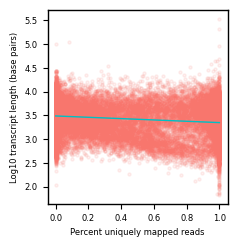

In [42]:
sns.regplot(data=df_merged_length, x="Percent uniquely mapped reads", 
            y="Log10 transcript length", scatter_kws={"color": ggplot2_colors[0], "alpha": 0.1, "s":5},
            line_kws={"color": ggplot2_colors[4], "alpha": 1, "linewidth":1})


plt.ylabel("Log10 transcript length (base pairs)")

spearman_coeff, spearman_p = stats.spearmanr(df_merged_length["Percent uniquely mapped reads"].copy(),
                                                                     df_merged_length["Log10 transcript length"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_merged_length["Percent uniquely mapped reads"].copy(),
                                                                     df_merged_length["Log10 transcript length"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/transcript_length_vs_uniquely_mapped.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/transcript_length_vs_uniquely_mapped.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

# XY plot CPM vs full length reads

In [43]:
## Calculate average CPM across all samples
df_cpm_total = df_cpm.filter(regex="trans|gene|median_CPM").copy()
df_cpm_total["Log10 median CPM"] = np.log10(df_cpm_total["median_CPM"].copy())
df_cpm_total.drop(columns="median_CPM", inplace=True)

In [44]:
## Add average CPM to the merged length 
df_merged_length = df_merged_length.merge(df_cpm_total, how="inner")

In [45]:
df_merged_length.head()

,transcript_id,total_counts,total_full_counts,real_transcript_length,total_unique_counts,Percent uniquely mapped full length reads,Percent uniquely mapped reads,Log10 transcript length,gene_id,Log10 median CPM
0,BambuTx1,852.339799,257.96618,495.0,0,0.302656,0.000000,2.694605,ENSG00000227232,0.353147
1,BambuTx5,2231.695591,1103.00000,602.0,1706,0.494243,0.764441,2.779596,ENSG00000078808,0.762303
2,BambuTx6,811.085006,643.00000,329.0,651,0.792765,0.802629,2.517196,ENSG00000284740,0.493458
3,BambuTx17,1566.777468,61.00000,1568.0,604,0.038933,0.385505,3.195346,ENSG00000251503,0.550840
4,BambuTx26,1060.201519,314.00000,885.0,624,0.296170,0.588567,2.946943,ENSG00000117245,0.399674


Spearman coefficient: 0.01
Spearman R-squared: 0.0
Spearman p-value: 0.13262649942349766

Pearson coefficient: -0.03
Pearson R-squared: 0.0
Pearson Slope: -0.07
Pearson Intercept: 0.83
Pearson P-value: 8.390047592394067e-07
Pearson Standard Error: 0.0144 



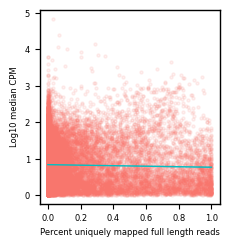

In [46]:
sns.regplot(data=df_merged_length, x="Percent uniquely mapped full length reads", 
            y="Log10 median CPM", scatter_kws={"color": ggplot2_colors[0], "alpha": 0.1, "s":5},
            line_kws={"color": ggplot2_colors[4], "alpha": 1, "linewidth":1})



spearman_coeff, spearman_p = stats.spearmanr(df_merged_length["Percent uniquely mapped full length reads"].copy(),
                                                                     df_merged_length["Log10 median CPM"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_merged_length["Percent uniquely mapped full length reads"].copy(),
                                                                     df_merged_length["Log10 median CPM"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/median_cpm_vs_full_length_uniquely_mapped.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/median_cpm_vs_full_length_uniquely_mapped.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

Spearman coefficient: -0.08
Spearman R-squared: 0.01
Spearman p-value: 1.969700470664746e-39

Pearson coefficient: -0.04
Pearson R-squared: 0.0
Pearson Slope: -0.05
Pearson Intercept: 0.85
Pearson P-value: 9.574673730012938e-10
Pearson Standard Error: 0.0087 



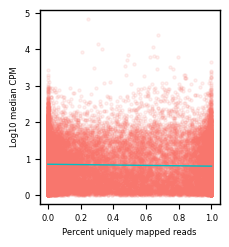

In [47]:
sns.regplot(data=df_merged_length, x="Percent uniquely mapped reads", 
            y="Log10 median CPM", scatter_kws={"color": ggplot2_colors[0], "alpha": 0.1, "s":5},
            line_kws={"color": ggplot2_colors[4], "alpha": 1, "linewidth":1})

spearman_coeff, spearman_p = stats.spearmanr(df_merged_length["Percent uniquely mapped reads"].copy(),
                                                                     df_merged_length["Log10 median CPM"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_merged_length["Percent uniquely mapped reads"].copy(),
                                                                     df_merged_length["Log10 median CPM"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")


plt.savefig('../../../figures/bernardo/02.quality_control/median_cpm_vs_uniquely_mapped.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/median_cpm_vs_uniquely_mapped.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

# Histogram of CPM expression at gene and transcript level

In [48]:
## Import transcripts
df_transcripts = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt",
        sep="\t", low_memory=False, header=0)

df_transcripts = fix_column_names(df_transcripts, is_gene=False)

In [49]:
## Import Genes
df_genes = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_gene.txt",
        sep="\t", low_memory=False, header=0)

df_genes = fix_column_names(df_genes, is_gene=True)

In [50]:
df_genes = calculate_cpm(df_genes, is_gene=True)
df_transcripts = calculate_cpm(df_transcripts, is_gene=False)

In [51]:
df_genes["median_CPM"] = df_genes[df_genes.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_transcripts["median_CPM"] = df_transcripts[df_transcripts.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [52]:
df_genes = df_genes.loc[df_genes["median_CPM"] > 0]

In [53]:
## Use ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [54]:
## Get log total counts
log_median_cpm = np.log10(df_genes["median_CPM"])

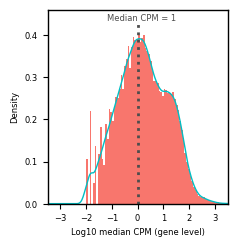

In [55]:
## Create log plot
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (59*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

log_median_cpm.plot(kind = "hist", density = True, bins = 100, color=ggplot2_colors[0], alpha=1) # change density to true, because KDE uses density


log_median_cpm.plot(kind = "kde", color=ggplot2_colors[4], alpha=1, linewidth=1)

plt.xlabel("Log10 median CPM (gene level)", size=6)
plt.ylim([0, 0.46])
plt.xlim([-3.5, 3.5])

plt.axvline(0, ymax=0.94, alpha=1, linestyle = ":", color="#4D4D4D", linewidth=2)
plt.text(x=-1.2, y=0.435, s="Median CPM = 1", alpha=1, color="#4D4D4D", size=6)

plt.savefig('../../../figures/bernardo/02.quality_control/gene_level_density_plot_log10_median_cpm.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/gene_level_density_plot_log10_median_cpm.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [56]:
df_transcripts = df_transcripts.loc[df_transcripts["median_CPM"] > 0]

In [57]:
## Get log total counts
log_median_cpm = np.log10(df_transcripts["median_CPM"])

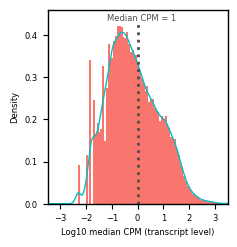

In [58]:
## Create log plot
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (59*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1


log_median_cpm.plot(kind = "hist", density = True, bins = 100, color=ggplot2_colors[0], alpha=1) # change density to true, because KDE uses density


log_median_cpm.plot(kind = "kde", color=ggplot2_colors[4], alpha=1, linewidth=1)


plt.xlabel("Log10 median CPM (transcript level)", size=6)
plt.ylim([0, 0.46])
plt.xlim([-3.5, 3.5])


plt.axvline(0, ymax=0.94, alpha=1, linestyle = ":", color="#4D4D4D", linewidth=2)
plt.text(x=-1.2, y=0.435, s="Median CPM = 1", alpha=1, color="#4D4D4D", size=6)


plt.savefig('../../../figures/bernardo/02.quality_control/transcript_level_density_plot_log10_median_cpm.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/transcript_level_density_plot_log10_median_cpm.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# - Total number of transcripts and genes across CPM threshold

In [59]:
## Import transcripts
df_transcripts = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt",
        sep="\t", low_memory=False, header=0)

df_transcripts = fix_column_names(df_transcripts, is_gene=False)

In [60]:
## Import Genes
df_genes = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_gene.txt",
        sep="\t", low_memory=False, header=0)

df_genes = fix_column_names(df_genes, is_gene=True)

In [61]:
df_genes = calculate_cpm(df_genes, is_gene=True)
df_transcripts = calculate_cpm(df_transcripts, is_gene=False)

In [62]:
df_genes["median_CPM"] = df_genes[df_genes.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_transcripts["median_CPM"] = df_transcripts[df_transcripts.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [63]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []
list_num_transcripts_median = []
list_num_genes_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    transcript_median_num = df_transcripts.loc[df_transcripts["median_CPM"] >= cpm_thresh].shape[0]
    
    gene_median_num = df_genes.loc[df_genes["median_CPM"] >= cpm_thresh].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_transcripts_median.append(transcript_median_num)
    
    list_num_genes_median.append(gene_median_num)

In [65]:
list_num_transcripts_median[101]

28989

In [64]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (56*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

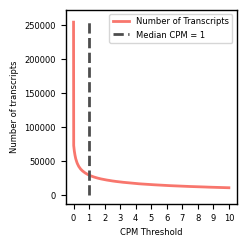

In [65]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_transcripts_median, color=ggplot2_colors[0], 
         label="Number of Transcripts", linewidth=2, alpha=1)
plt.plot([1, 1], [-100, 260000], color="#4D4D4D", label="Median CPM = 1", linewidth=2, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of transcripts')
plt.legend(loc="upper right")

plt.savefig('../../../figures/bernardo/02.quality_control/number_of_transcripts_across_cpm_thresh.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/02.quality_control/number_of_transcripts_across_cpm_thresh.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

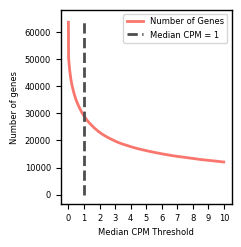

In [66]:
## Make plot showing number of genes across CPM thresholds (Both)

plt.plot(list_cpm_thresh, list_num_genes_median, color=ggplot2_colors[0], 
         label="Number of Genes", linewidth=2, alpha=1)
plt.plot([1, 1], [-100, 65000], color="#4D4D4D", label="Median CPM = 1", linewidth=2, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of genes')
plt.legend(loc="upper right")

plt.savefig('../../../figures/bernardo/02.quality_control/number_of_genes_across_cpm_thresh.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/02.quality_control/number_of_genes_across_cpm_thresh.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()


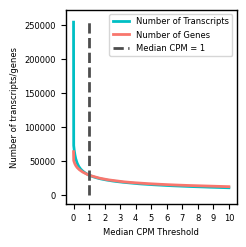

In [67]:
## Make plot showing number of genes and transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_transcripts_median, color=ggplot2_colors[4], 
         label="Number of Transcripts", linewidth=2, alpha=1)

plt.plot(list_cpm_thresh, list_num_genes_median, color=ggplot2_colors[0], 
         label="Number of Genes", linewidth=2, alpha=1)

plt.plot([1, 1], [-100, 260000], color="#4D4D4D", label="Median CPM = 1", linewidth=2, alpha=1, linestyle='dashed')



plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of transcripts/genes')
plt.legend(loc="upper right")

plt.savefig('../../../figures/bernardo/02.quality_control/number_of_genes_and_transcripts_across_cpm_thresh.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/02.quality_control/number_of_genes_and_transcripts_across_cpm_thresh.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [68]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (59*mm, 64*mm)
rcParams.update({'font.size': 5})
rcParams['axes.linewidth'] = 1

# ERCC correlation plot

In [69]:
ercc_baseline = pd.read_csv("../../../references/bernardo/ercc_baseline.csv")

In [70]:
df_ercc = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

In [71]:
df_ercc = fix_column_names(df_ercc, is_gene=False)
df_ercc = calculate_cpm(df_ercc, is_gene=False)

In [72]:
df_ercc = df_ercc.loc[df_ercc["gene_id"].str.startswith("ERCC")].copy()

In [73]:
df_ercc = df_ercc.filter(regex="transc|gene|CPM").copy()

In [74]:
df_ercc_melt = pd.melt(df_ercc, value_vars=df_ercc.columns[2:],
                                         id_vars=['gene_id', "transcript_id"], var_name='sample', value_name='CPM')

In [75]:
df_ercc_melt = df_ercc_melt.merge(ercc_baseline, on="gene_id", how="inner")

Spearman coefficient: 0.95
Spearman R-squared: 0.91
Spearman p-value: 0.0

Pearson coefficient: 0.87
Pearson R-squared: 0.75
Pearson Slope: 0.12
Pearson Intercept: 16.5
Pearson P-value: 0.0
Pearson Standard Error: 0.002 



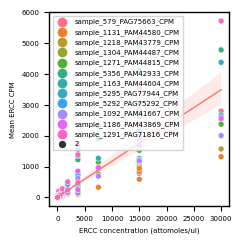

In [76]:
sns.regplot(data=df_ercc_melt, x="concentration", y="CPM", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.0, "s":2}, line_kws={"linewidth":1})

sns.scatterplot(data=df_ercc_melt, x="concentration", y="CPM", hue="sample", size=2)

plt.ylabel("Mean ERCC CPM")
plt.xlabel("ERCC concentration (attomoles/ul)")
plt.legend(fontsize=5)

spearman_coeff, spearman_p = stats.spearmanr(df_ercc_melt["concentration"].copy(),
                                                                     df_ercc_melt["CPM"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_ercc_melt["concentration"].copy(),
                                                                     df_ercc_melt["CPM"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")


plt.savefig('../../../figures/bernardo/02.quality_control/ercc_correlation_colored_by_sample.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/ercc_correlation_colored_by_sample.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

Spearman coefficient: 0.95
Spearman R-squared: 0.91
Spearman p-value: 0.0

Pearson coefficient: 0.87
Pearson R-squared: 0.75
Pearson Slope: 0.12
Pearson Intercept: 16.5
Pearson P-value: 0.0
Pearson Standard Error: 0.002 



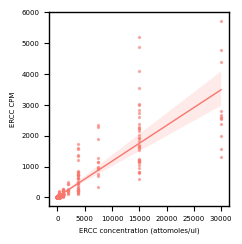

In [77]:
sns.regplot(data=df_ercc_melt, x="concentration", y="CPM", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":2}, line_kws={"linewidth":1})


plt.ylabel("ERCC CPM")
plt.xlabel("ERCC concentration (attomoles/ul)")

spearman_coeff, spearman_p = stats.spearmanr(df_ercc_melt["concentration"].copy(),
                                                                     df_ercc_melt["CPM"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_ercc_melt["concentration"].copy(),
                                                                     df_ercc_melt["CPM"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/ercc_correlation_by_sample.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/ercc_correlation_by_sample.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

In [78]:
list_ercc_cpm = []
list_samples = []

for col in df_ercc.columns[2:]:
    
    total_errc_CPM = df_ercc[col].copy().sum()
    
    list_ercc_cpm.append(total_errc_CPM)
    list_samples.append(col.split("ample_")[1].split("_CP")[0])

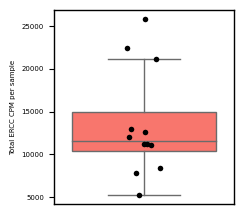

In [79]:
sns.boxplot(data=list_ercc_cpm, color=ggplot2_colors[0], saturation=1,
           showfliers=False, dodge=True, linewidth=1).set(xticklabels=[])


g = sns.stripplot(data=list_ercc_cpm, color="black", size=4, dodge=True)

plt.ylabel("Total ERCC CPM per sample")
plt.xlabel("")
plt.tick_params(bottom=False)

plt.savefig('../../../figures/bernardo/02.quality_control/total_ercc_cpm.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/total_ercc_cpm.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

In [80]:
d = {'ERCC CPM': list_ercc_cpm, 'Sample Name': list_samples, "Other": np.zeros(12)}

df_plot = pd.DataFrame(data=d)

In [81]:
df_plot_2 = df_plot.loc[((df_plot["ERCC CPM"] < 6000) | (df_plot["ERCC CPM"] > 14000))]

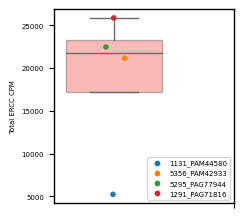

In [82]:
sns.boxplot(data=df_plot_2, x="Other", y='ERCC CPM', color=ggplot2_colors[0], saturation=1,
           showfliers=False, dodge=True, boxprops=dict(alpha=0.5), linewidth=1)


g = sns.stripplot(data=df_plot_2, x="Other", y='ERCC CPM', hue="Sample Name", size=4)

plt.ylabel("Total ERCC CPM")
plt.legend(fontsize=5)
plt.xlabel("")
plt.xticks("")


for lh in g.legend_.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [10] 

In [83]:
df_ercc_2 = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_ercc_2["mean"] = df_ercc_2[df_ercc_2.columns[2:]].sum(axis=1)


df_ercc_2 = fix_column_names(df_ercc_2, is_gene=False)
df_ercc_2.drop(columns=df_ercc_2.filter(regex="[0-9]_counts").columns, inplace=True)

df_ercc_2 = calculate_cpm(df_ercc_2, is_gene=False)
df_ercc_2.drop(columns="mean_counts", inplace=True)

df_ercc_2 = df_ercc_2.merge(ercc_baseline, on="gene_id", how="inner")

In [84]:
rcParams.update({'font.size': 5})

Spearman coefficient: 0.98
Spearman R-squared: 0.96
Spearman p-value: 4.726589615380758e-64

Pearson coefficient: 0.95
Pearson R-squared: 0.91
Pearson Slope: 0.12
Pearson Intercept: 16.84
Pearson P-value: 3.574852084939422e-49
Pearson Standard Error: 0.0038 



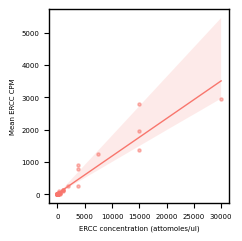

In [85]:
sns.regplot(data=df_ercc_2, x="concentration", y="mean_CPM", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":5}, line_kws={"linewidth": 1})

plt.ylabel("Mean ERCC CPM")
plt.xlabel("ERCC concentration (attomoles/ul)")

spearman_coeff, spearman_p = stats.spearmanr(df_ercc_2["concentration"].copy(),
                                                                     df_ercc_2["mean_CPM"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_ercc_2["concentration"].copy(),
                                                                     df_ercc_2["mean_CPM"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/ercc_correlation_by_mean_cpm.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/ercc_correlation_by_mean_cpm.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

In [86]:
rcParams.update({'font.size': 6})

In [87]:
df_plot["sample_name"] = "sample_" + df_plot["Sample Name"]

df_last = df_qc_stats.merge(df_plot, on="sample_name", how="inner")

Spearman coefficient: 0.45
Spearman R-squared: 0.21
Spearman p-value: 0.13765791634772945

Pearson coefficient: 0.33
Pearson R-squared: 0.11
Pearson Slope: 26.2
Pearson Intercept: 4060.21
Pearson P-value: 0.2966447714312801
Pearson Standard Error: 23.7937 



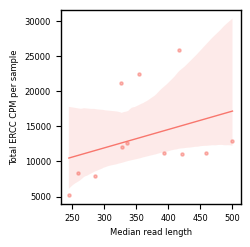

In [88]:
sns.regplot(data=df_last, x="Median read length mapped", y="ERCC CPM", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":5}, line_kws={"linewidth": 1})

plt.ylabel("Total ERCC CPM per sample")
plt.xlabel("Median read length")

spearman_coeff, spearman_p = stats.spearmanr(df_last["Median read length mapped"].copy(),
                                                                     df_last["ERCC CPM"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_last["Median read length mapped"].copy(),
                                                                     df_last["ERCC CPM"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../../figures/bernardo/02.quality_control/ercc_cpm_total_vs_median_read_length.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/02.quality_control/ercc_cpm_total_vs_median_read_length.svg',
            dpi=1200, transparent=True, bbox_inches="tight")